In [8]:
# This code is for simulation polarimetric calibration, after correction for in-homogeneity.

import cv2
import polanalyser as pa
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpldatacursor import datacursor


In [9]:
#Simulate groud truth normalized Stokes Vector
def sim_GT_Snorm(AoLP_true = np.deg2rad(range(0,185,5)), DoLP_true = 0.999, haxis = 2448, vaxis = 2048, n_im = 37):
    GT_Snorm = np.ones([3,n_im,vaxis,haxis])
    q_true_val = DoLP_true*np.cos(2*AoLP_true)
    u_true_val = DoLP_true*np.sin(2*AoLP_true)
    for i in range(n_im):
        GT_Snorm[1,i,:,:] = q_true_val[i]
        GT_Snorm[2,i,:,:] = u_true_val[i]
    return GT_Snorm

In [10]:
#Simulate mono images, no demosaicing
def sim_Noisy_images(GT_Snorm, noise_std=5):
    t_guess = 1
    alpha_d = np.ones(GT_Snorm[0].shape)
    alpha_d[:,1::2, 1::2]=  0
    alpha_d[:,0::2, 1::2]=  45
    alpha_d[:,0::2, 0::2]=  90
    alpha_d[:,1::2, 0::2]=  135
    alpha = np.deg2rad(alpha_d)
    L = 0.5*t_guess*(GT_Snorm[0]+ GT_Snorm[1]*np.cos(2*alpha)+GT_Snorm[2]*np.sin(2*alpha))
    noise =  np.random.normal(0.0,noise_std/100,L.shape)
    L_noise = L*(1+noise)
    return L_noise

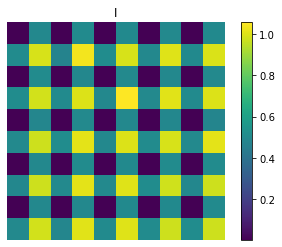

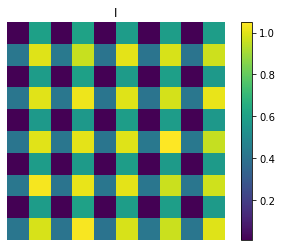

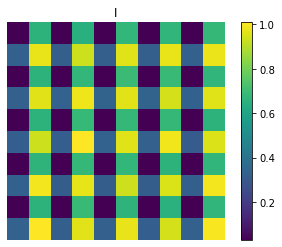

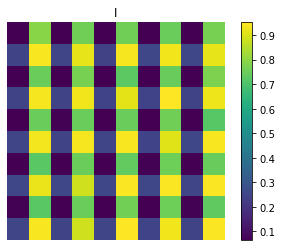

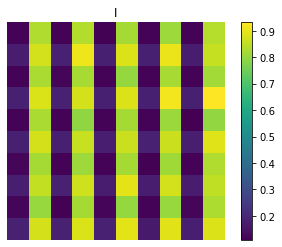

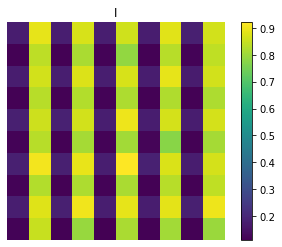

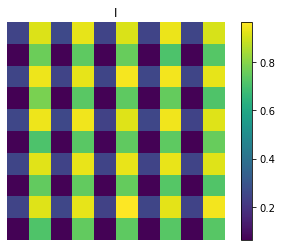

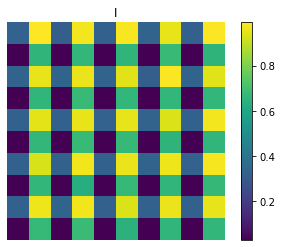

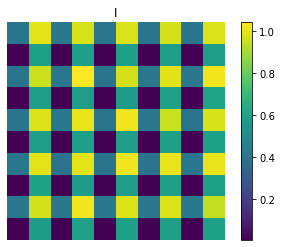

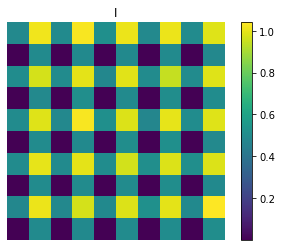

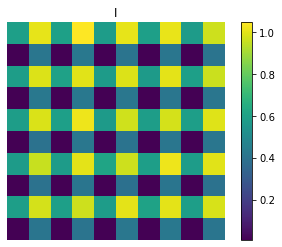

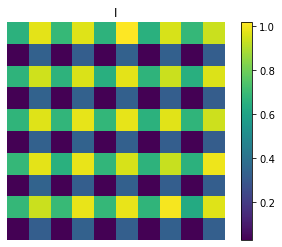

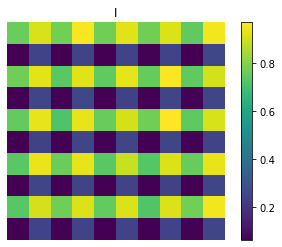

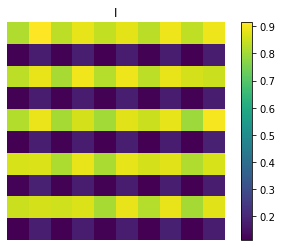

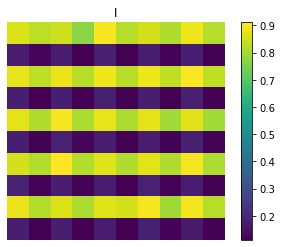

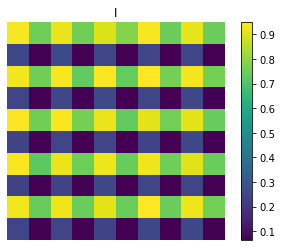

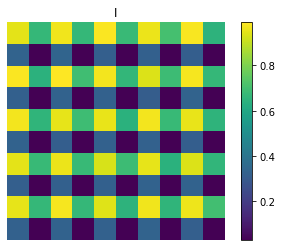

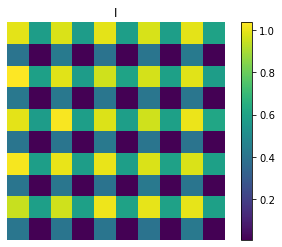

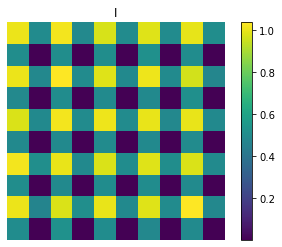

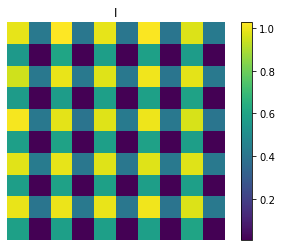

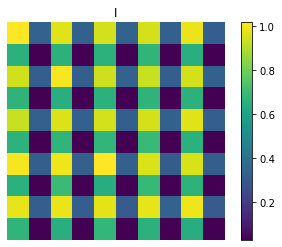

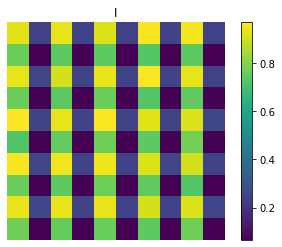

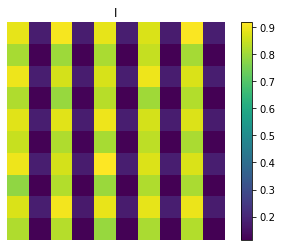

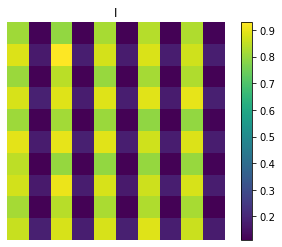

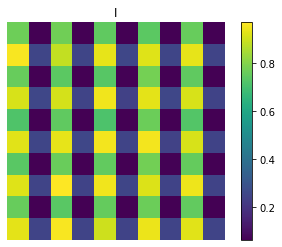

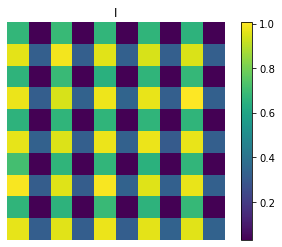

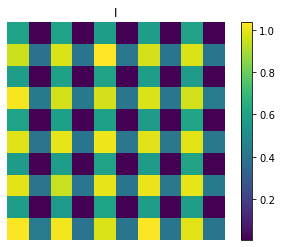

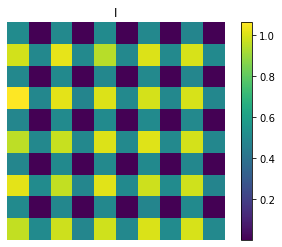

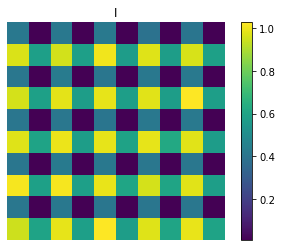

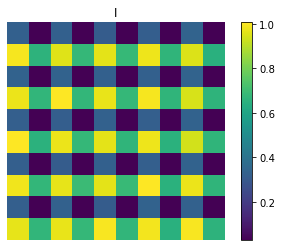

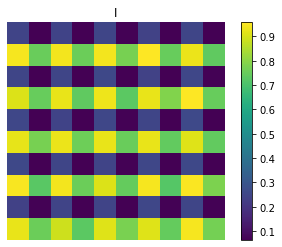

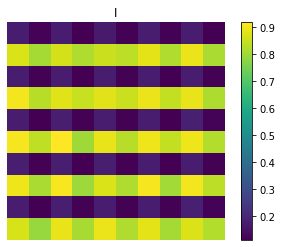

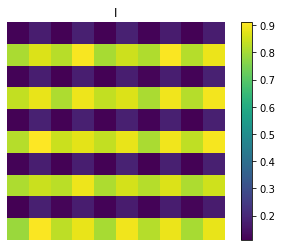

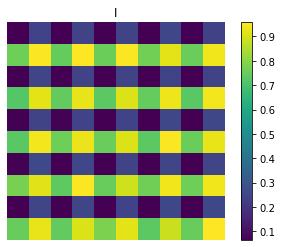

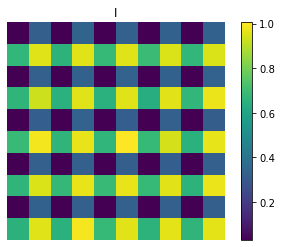

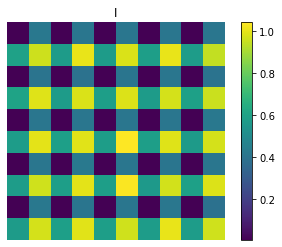

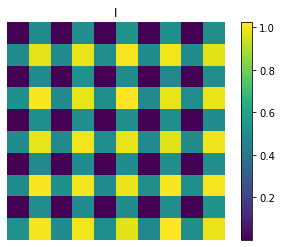

In [11]:
#Show noisy images
def save_sim_images(images,show = False):
    for i in range(images.shape[0]):
        plt.figure()
        im1 = plt.imshow(images[i,:,:])
        im = Image.fromarray(images[i,:,:])
        im.save(f'{i}.tiff')
        plt.colorbar(im1)
        datacursor()
        plt.title('I')
        plt.axis('off')
        if show:
           plt.show()

In [12]:
def mean_error(images, DoLP_true = 0.999, AoLP_true = np.deg2rad(range(0,185,5)), calibrate = False):
    n_im = images.shape[0]
    vaxis = images.shape[1]
    haxis = images.shape[2]
    DoLP_Error = np.zeros(n_im)
    AoLP_Error = np.zeros(n_im)
    AoLP_sum = 0
    for i in range(n_im):
        images_demosaiced = pa.demosaicing(images[i])
        img_0, img_45, img_90, img_135 = cv2.split(images_demosaiced)
        Stokes = pa.calcLinearStokes(np.array([img_0, img_45, img_90, img_135]), np.deg2rad([0,45,90,135]))
        if calibrate:
            X_mat = Cal_params(images)
            Stokes_cal = Cal(Stokes, X_mat)
            Stokes = Stokes_cal
        DoLP_with_noise= pa.cvtStokesToDoLP(Stokes)
        AoLP_with_noise = pa.cvtStokesToAoLP(Stokes)
        DoLP_Error[i] = np.sum(np.abs(DoLP_with_noise-DoLP_true))
        AoLP_Error[i] = np.sum(np.abs(AoLP_with_noise-AoLP_true[i]))
        AoLP_sum +=  haxis*vaxis*AoLP_true[i]
    mean_DoLP_Error = np.sum(DoLP_Error)/(n_im*haxis*vaxis*DoLP_true)
    mean_AoLP_Error = np.sum(AoLP_Error)/AoLP_sum
    return [mean_DoLP_Error, mean_AoLP_Error]

ValueError: shape-mismatch for sum

In [ ]:
def Cal_params(images, GT_Snorm):
    #calibration

    n_im = images.shape[0]
    haxis = images.shape[1]
    vaxis = images.shape[2]

    images = np.zeros([n_im,haxis,vaxis])
    B_Mat = np.zeros([n_im,haxis*vaxis])
    A_Mat = np.zeros([n_im, 3])
    q_true = GT_Snorm[1,:,1,1]
    u_true = GT_Snorm[2,:,1,1]

    for i in range(n_im):
        B_Mat[i] = images[i].flatten()

    A_Mat[:,0]=1
    A_Mat[:,1] = np.transpose(q_true)
    A_Mat[:,2] = np.transpose(u_true)

    # for real images we need normalization
    #    I = 0.5*(images[:,1::2, 1::2]+images[:,0::2, 1::2]+images[:,0::2, 0::2]+images[:,1::2, 0::2])
    #    images[:,1::2, 1::2]=  images[:,1::2, 1::2]/I
    #    images[:,0::2, 1::2]=  images[:,0::2, 1::2]/I
    #    images[:,0::2, 0::2]=  images[:,0::2, 0::2]/I
    #    images[:,1::2, 0::2]=  images[:,1::2, 0::2]/I

    x = np.linalg.lstsq(A_Mat, B_Mat)
    X_mat = np.reshape(np.array(x[0]),[3,haxis,vaxis])# each column has the three parameters for a pixel
    return X_mat

In [ ]:
def Cal(Stokes, X_mat):
    Stokes_cal = np.ones(Stokes.shape)
    q_meas = Stokes[1]
    u_meas = Stokes[2]
    H = q_meas.shape[0]
    V = q_meas.shape[1]
    a1_in = pa.demosaicing(X_mat[0])
    a2_in = pa.demosaicing(X_mat[1])
    a3_in = pa.demosaicing(X_mat[2])
    a1, c1, b1, d1 = cv2.split(a1_in)
    a2, c2, b2, d2 = cv2.split(a2_in)
    a3, c3, b3, d3 = cv2.split(a3_in)
    ab1 = a1-b1
    cd1 = c1-d1
    ab2 = a2-b2
    cd2 = c2-d2
    ab3 = a3-b3
    cd3 = c3-d3
    for i in range(H):
        for j in range(V):
            M = np.array([[ab2[i,j], ab3[i,j]],[cd2[i,j], cd3[i,j]]])
            Min = np.linalg.inv(M)
            S =  np.array([[q_meas[i,j]],[u_meas[i,j]]])
            Scal = np.matmul(Min, S)
            Stokes_cal[1,i,j]=Scal[0,0]
            Stokes_cal[2,i,j]=Scal[0,1]
    return  Stokes_cal


In [17]:
dir = "C:/Users/masadatz/Google Drive/CloudCT/svs_vistek"
tifCounter = len(glob.glob1(dir,"*.tiff"))
read_images = np.zeros([tifCounter,10,10])
for (i,file) in zip(range(tifCounter),glob.glob1(dir,f'*.tiff')):
    read_images[i]= np.asarray(Image.open(file))


m_error_0 = mean_error(read_images)
m_error_1 = mean_error(read_images,calibrate=True)